# Import Libraries

In [ ]:
# ------------------- IMPORTS -------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Load datasets

In [ ]:
users_df = pd.read_csv('data/users.csv')
jobs_df = pd.read_csv('data/jobs.csv')
courses_df = pd.read_csv('data/courses.csv')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10,6)

# Distribution of Skills

C:\Users\hariv\AppData\Local\Temp\ipykernel_5668\1091463489.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=all_skills.values, y=all_skills.index, palette="viridis")


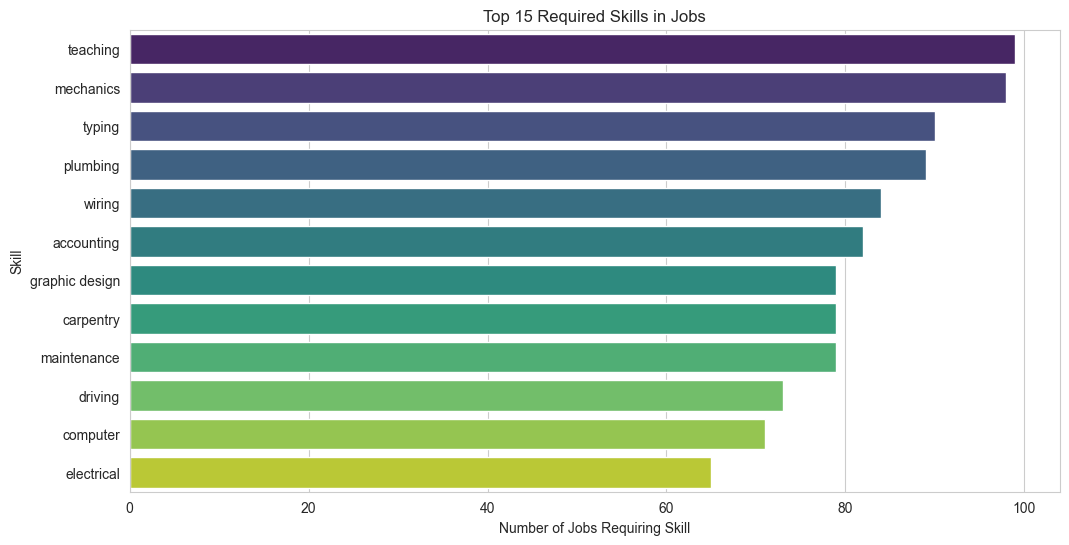

In [2]:
# Count most common skills in jobs dataset
jobs_df['required_skills'] = jobs_df['required_skills'].fillna('')
all_skills = jobs_df['required_skills'].str.split(',', expand=True).stack().str.strip().value_counts().head(15)

plt.figure(figsize=(12,6))
sns.barplot(x=all_skills.values, y=all_skills.index, palette="viridis")
plt.title("Top 15 Required Skills in Jobs")
plt.xlabel("Number of Jobs Requiring Skill")
plt.ylabel("Skill")
plt.show()


# Jobs by Region

C:\Users\hariv\AppData\Local\Temp\ipykernel_5668\175082628.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_counts.index, y=region_counts.values, palette="coolwarm")


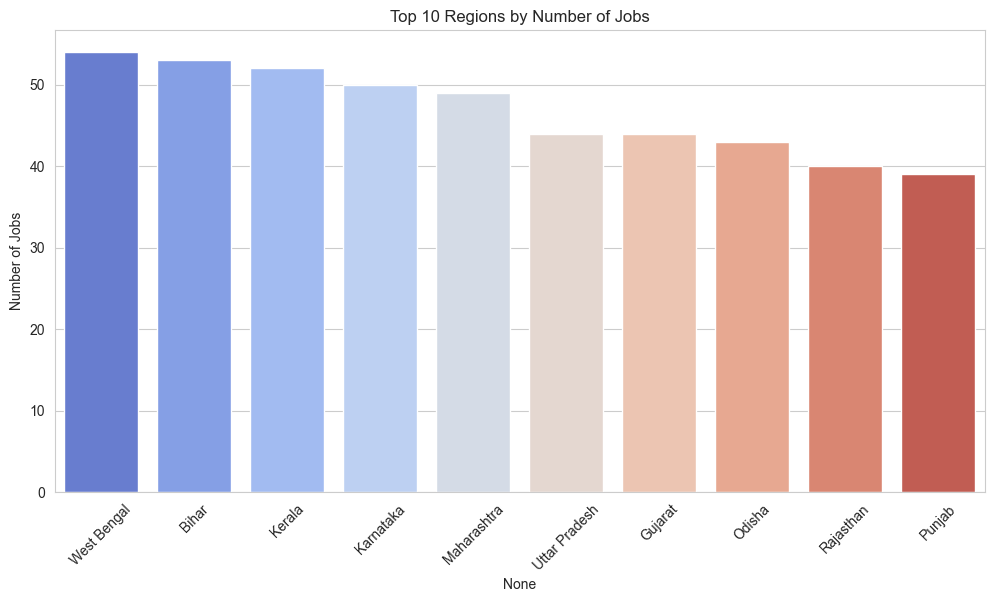

In [3]:
region_counts = jobs_df['region'].value_counts().head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=region_counts.index, y=region_counts.values, palette="coolwarm")
plt.title("Top 10 Regions by Number of Jobs")
plt.xticks(rotation=45)
plt.ylabel("Number of Jobs")
plt.show()


# Job Types Distribution

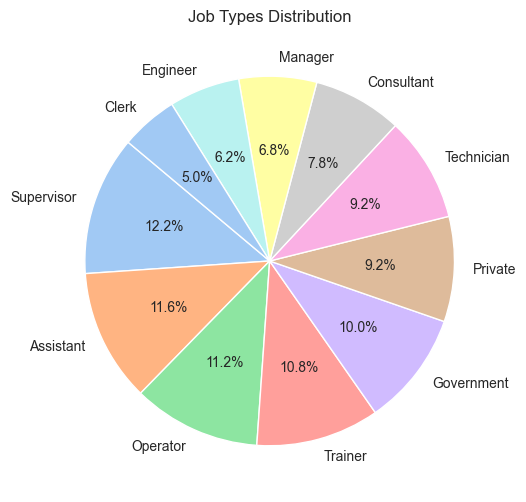

In [4]:
job_type_counts = jobs_df['job_type'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(job_type_counts, labels=job_type_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title("Job Types Distribution")
plt.show()


# Top Companies Hiring

C:\Users\hariv\AppData\Local\Temp\ipykernel_5668\4215718381.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_companies.values, y=top_companies.index, palette="magma")


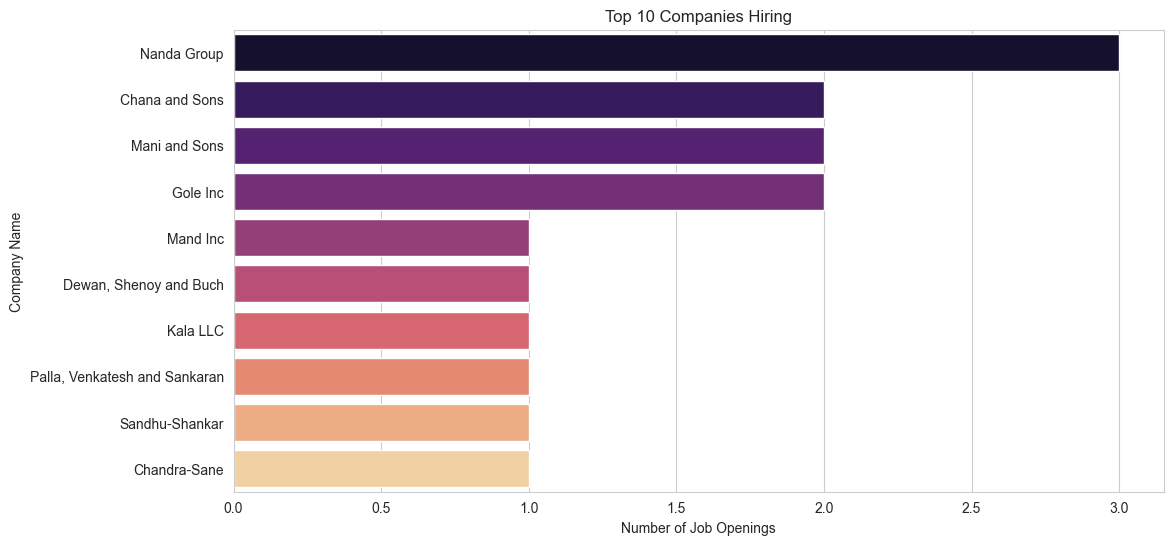

In [5]:
top_companies = jobs_df['company_name'].value_counts().head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=top_companies.values, y=top_companies.index, palette="magma")
plt.title("Top 10 Companies Hiring")
plt.xlabel("Number of Job Openings")
plt.ylabel("Company Name")
plt.show()


# Courses by Skill

C:\Users\hariv\AppData\Local\Temp\ipykernel_5668\383732780.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=all_course_skills.values, y=all_course_skills.index, palette="cubehelix")


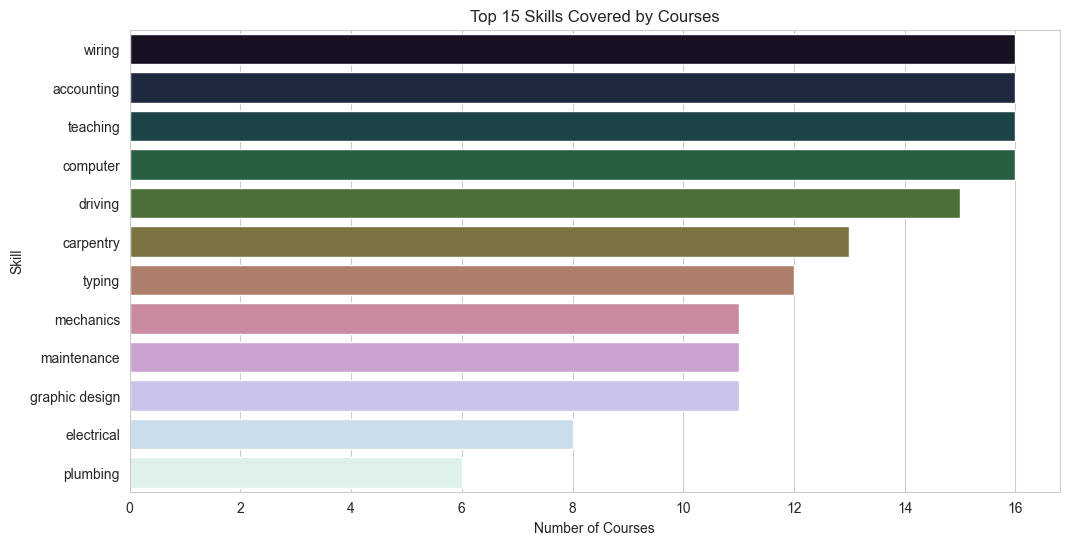

In [6]:
courses_df['related_skill'] = courses_df['related_skill'].fillna('')
all_course_skills = courses_df['related_skill'].str.split(',', expand=True).stack().str.strip().value_counts().head(15)

plt.figure(figsize=(12,6))
sns.barplot(x=all_course_skills.values, y=all_course_skills.index, palette="cubehelix")
plt.title("Top 15 Skills Covered by Courses")
plt.xlabel("Number of Courses")
plt.ylabel("Skill")
plt.show()


# Courses by Provider

C:\Users\hariv\AppData\Local\Temp\ipykernel_5668\2792439955.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=provider_counts.values, y=provider_counts.index, palette="Set2")


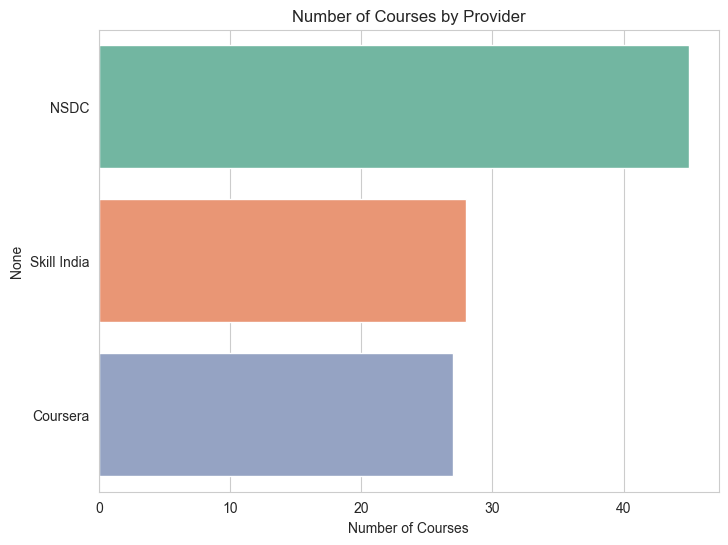

In [7]:
provider_counts = courses_df['provider'].value_counts()
plt.figure(figsize=(8,6))
sns.barplot(x=provider_counts.values, y=provider_counts.index, palette="Set2")
plt.title("Number of Courses by Provider")
plt.xlabel("Number of Courses")
plt.show()


# Jobs vs Education Level

C:\Users\hariv\AppData\Local\Temp\ipykernel_5668\2107601500.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=education_counts.values, y=education_counts.index, palette="Blues_r")


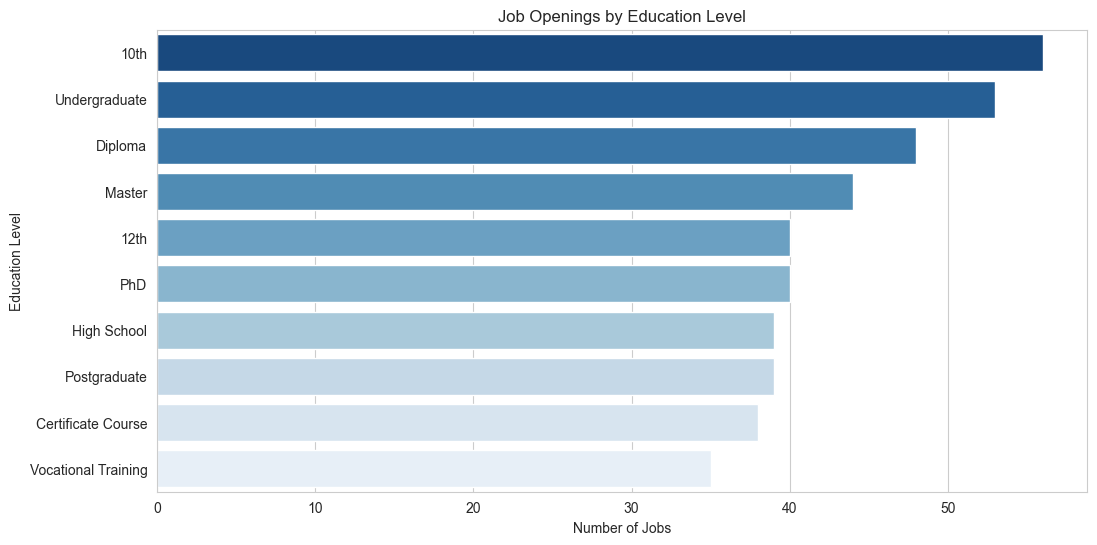

In [8]:
education_counts = jobs_df['education_required'].value_counts().head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=education_counts.values, y=education_counts.index, palette="Blues_r")
plt.title("Job Openings by Education Level")
plt.xlabel("Number of Jobs")
plt.ylabel("Education Level")
plt.show()


# **TF-IDF with Random Forest Classifier**

Random Forest Classifier: Use TF-IDF features derived from skills and education to train a Random Forest Classifier.

Model Accuracy: 0.11

Classification Report:
              precision    recall  f1-score   support

   Assistant       0.00      0.00      0.00        11
       Clerk       0.25      0.12      0.17         8
  Consultant       0.33      0.08      0.12        13
    Engineer       0.00      0.00      0.00         5
  Government       0.00      0.00      0.00        10
     Manager       0.23      0.33      0.27         9
    Operator       0.13      0.25      0.17         8
     Private       0.10      0.14      0.12         7
  Supervisor       0.14      0.08      0.11        12
  Technician       0.00      0.00      0.00         8
     Trainer       0.11      0.22      0.14         9

    accuracy                           0.11       100
   macro avg       0.12      0.11      0.10       100
weighted avg       0.13      0.11      0.10       100



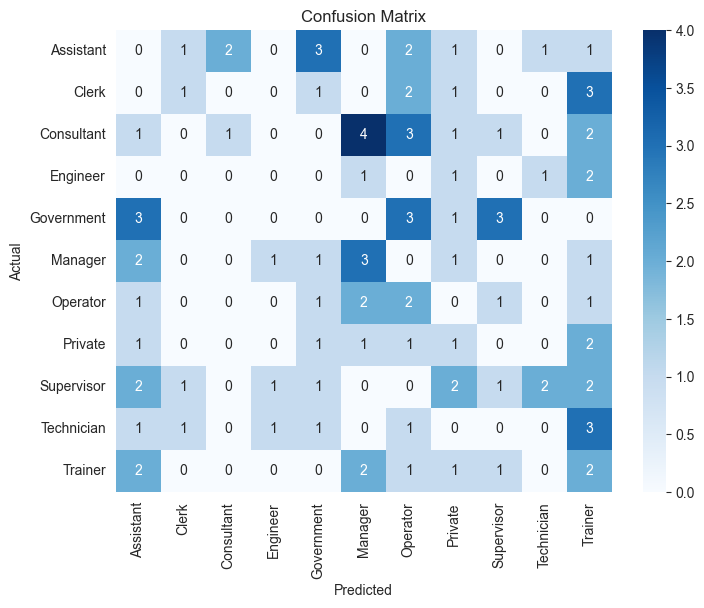

In [15]:
# Fill missing values
jobs_df['required_skills'] = jobs_df['required_skills'].fillna('')
jobs_df['education_required'] = jobs_df['education_required'].fillna('')
jobs_df['region'] = jobs_df['region'].fillna('')
jobs_df['language_preference'] = jobs_df['language_preference'].fillna('')
jobs_df['job_type'] = jobs_df['job_type'].fillna('Unknown')

# Combine text features for TF-IDF
jobs_df['combined_text'] = jobs_df['required_skills'] + ' ' + jobs_df['education_required']

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=500)
X_text = vectorizer.fit_transform(jobs_df['combined_text'])

# Encode categorical features (region + language)
region_encoder = LabelEncoder()
language_encoder = LabelEncoder()
X_region = region_encoder.fit_transform(jobs_df['region']).reshape(-1,1)
X_language = language_encoder.fit_transform(jobs_df['language_preference']).reshape(-1,1)

# Combine all features
from scipy.sparse import hstack
X = hstack([X_text, X_region, X_language])

# Encode target (job_type)
y_encoder = LabelEncoder()
y = y_encoder.fit_transform(jobs_df['job_type'])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=y_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=y_encoder.classes_, yticklabels=y_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [12]:
!pip install wordcloud


  Using cached wordcloud-1.9.4-cp311-cp311-win_amd64.whl.metadata (3.5 kB)
Using cached wordcloud-1.9.4-cp311-cp311-win_amd64.whl (299 kB)


# **TF-IDF with Multinomial Naive Bayes**

Multinomial Naive Bayes: Combine similar skills and education entries, vectorize them using TF-IDF, and train a Multinomial Naive Bayes model

   job_id        job_title                     company_name  \
0       1  Sales Executive                      Pandit-Tata   
1       2      Electrician  Krishnamurthy, Cherian and Shah   
2       3  Sales Executive                     Kothari-Kota   
3       4           Driver                     Lall-Sachdev   
4       5   Civil Engineer          Mallick, Bakshi and Dey   

                         required_skills experience_required  \
0  graphic design, carpentry, accounting            3+ years   
1                      mechanics, wiring            0+ years   
2            mechanics, plumbing, typing            0+ years   
3          accounting, carpentry, wiring            3+ years   
4                             accounting            3+ years   

    education_required            salary    job_type     location  \
0  Vocational Training  ₹27725 per month  Government       Bhopal   
1                 12th  ₹48728 per month  Supervisor  Farrukhabad   
2                 10th  ₹3681

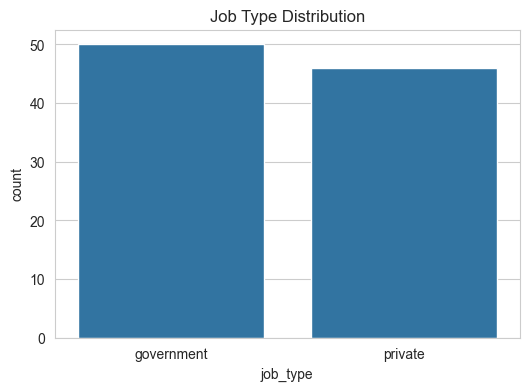

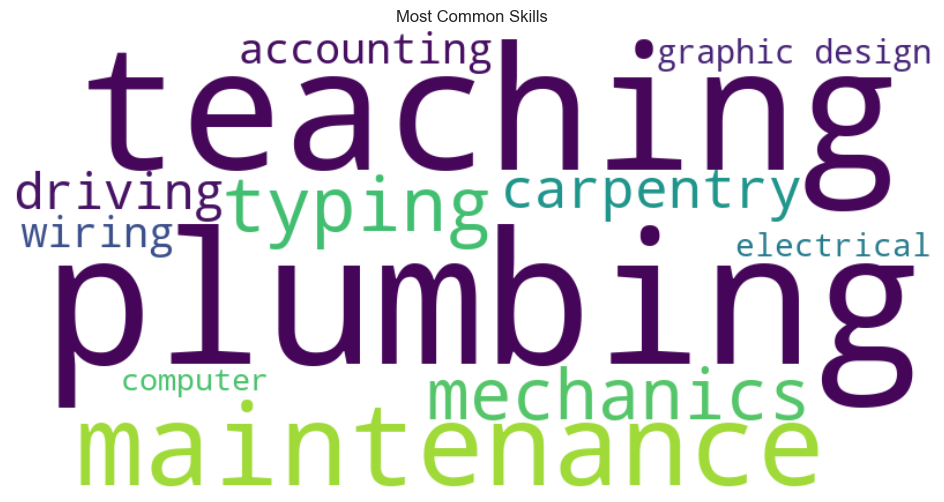

Accuracy: 0.65

Classification Report:
               precision    recall  f1-score   support

  government       0.62      0.80      0.70        10
     private       0.71      0.50      0.59        10

    accuracy                           0.65        20
   macro avg       0.66      0.65      0.64        20
weighted avg       0.66      0.65      0.64        20



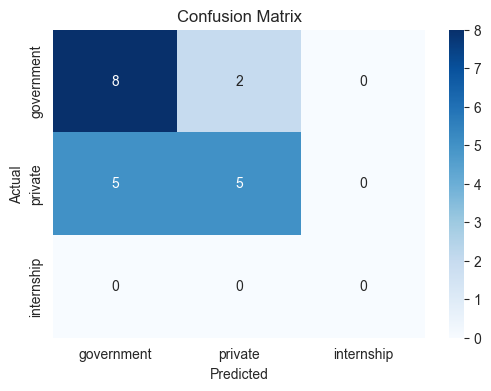


Top words for government:
['training', 'vocational', 'wiring', 'mechanics', 'accounting', 'master', 'teaching', 'computer', 'diploma', 'high', 'school', 'undergraduate', 'electrical', 'carpentry', 'typing', 'design', 'graphic', 'plumbing', 'maintenance', 'driving']

Top words for private:
['design', 'graphic', 'master', 'vocational', 'training', 'computer', '10th', 'maintenance', 'plumbing', 'undergraduate', '12th', 'phd', 'mechanics', 'carpentry', 'accounting', 'typing', 'wiring', 'school', 'high', 'teaching']


In [ ]:

# ------------------- LOAD DATA -------------------
jobs_df = pd.read_csv('data/jobs.csv')

# Quick look at data
print(jobs_df.head())

# ------------------- DATA CLEANING -------------------
# Fill missing values
jobs_df['required_skills'] = jobs_df['required_skills'].fillna('')
jobs_df['education_required'] = jobs_df['education_required'].fillna('')
jobs_df['job_type'] = jobs_df['job_type'].fillna('Unknown')

# Standardize job_type: keep main 3 classes
jobs_df['job_type'] = jobs_df['job_type'].str.lower()
jobs_df['job_type'] = jobs_df['job_type'].replace({
    'training': 'internship',
    'internship': 'internship',
    'government': 'government',
    'private': 'private'
})
jobs_df = jobs_df[jobs_df['job_type'].isin(['government','private','internship'])]

# Combine skills + education for text model
jobs_df['text_features'] = jobs_df['required_skills'] + ' ' + jobs_df['education_required']

# ------------------- VISUALIZATIONS -------------------
plt.figure(figsize=(6,4))
sns.countplot(x='job_type', data=jobs_df)
plt.title('Job Type Distribution')
plt.show()

# Top 20 skills word cloud
from wordcloud import WordCloud

skills_text = ' '.join(jobs_df['required_skills'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(skills_text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Skills')
plt.show()

# ------------------- MODEL TRAINING -------------------
X = jobs_df['text_features']
y = jobs_df['job_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Pipeline: TF-IDF + MultinomialNB
model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=500, stop_words='english')),
    ('clf', MultinomialNB())
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# ------------------- EVALUATION -------------------
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['government','private','internship'])
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['government','private','internship'], yticklabels=['government','private','internship'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ------------------- FEATURE IMPORTANCE (Optional) -------------------
# Show top 20 TF-IDF features per class
tfidf_vectorizer = model.named_steps['tfidf']
clf = model.named_steps['clf']
feature_names = tfidf_vectorizer.get_feature_names_out()

for i, class_label in enumerate(clf.classes_):
    top10 = np.argsort(clf.feature_log_prob_[i])[-20:]
    print(f"\nTop words for {class_label}:")
    print([feature_names[j] for j in top10])
